In [20]:
# # Built-in modules
# import math

# # Imports from Qiskit
# from qiskit import QuantumCircuit
# from qiskit.circuit.library import GroverOperator, MCMT, ZGate
# from qiskit.visualization import plot_distribution

# # Imports from Qiskit Runtime
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_ibm_runtime import SamplerV2 as Sampler


# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=True)
# backend.name


# def grover_oracle(marked_states):
#     """Build a Grover oracle for multiple marked states

#     Here we assume all input marked states have the same number of bits

#     Parameters:
#         marked_states (str or list): Marked states of oracle

#     Returns:
#         QuantumCircuit: Quantum circuit representing Grover oracle
#     """
#     if not isinstance(marked_states, list):
#         marked_states = [marked_states]
#     # Compute the number of qubits in circuit
#     num_qubits = len(marked_states[0])

#     qc = QuantumCircuit(num_qubits)
#     # Mark each target state in the input list
#     for target in marked_states:
#         # Flip target bit-string to match Qiskit bit-ordering
#         rev_target = target[::-1]
#         # Find the indices of all the '0' elements in bit-string
#         zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
#         # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
#         # where the target bit-string has a '0' entry
#         qc.x(zero_inds)
#         qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
#         qc.x(zero_inds)
#     return qc


# marked_states = ["011", "100"]

# oracle = grover_oracle(marked_states)
# oracle.draw(output="mpl", style="iqp")


# grover_op = GroverOperator(oracle)
# grover_op.decompose().draw(output="mpl", style="iqp")


# optimal_num_iterations = math.floor(
#     math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
# )


# qc = QuantumCircuit(grover_op.num_qubits)
# # Create even superposition of all basis states
# qc.h(range(grover_op.num_qubits))
# # Apply Grover operator the optimal number of times
# qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# # Measure all qubits
# qc.measure_all()
# qc.draw(output="mpl", style="iqp")


# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# target = backend.target
# pm = generate_preset_pass_manager(target=target, optimization_level=3)

# circuit_isa = pm.run(qc)
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")


# # To run on local simulator:
# #   1. Use the SatetvectorSampler from qiskit.primitives instead
# sampler = Sampler(mode=backend)
# sampler.options.default_shots = 10_000
# result = sampler.run([circuit_isa]).result()
# dist = result[0].data.meas.get_counts()

Measurement results:
{'11110': 1731, '01010': 37, '10000': 1697, '00001': 48, '11101': 1831, '10111': 1817, '11111': 43, '10001': 43, '01111': 36, '11011': 1734, '00011': 46, '01101': 56, '00000': 43, '01001': 48, '00111': 41, '10010': 35, '11100': 42, '00110': 45, '10110': 42, '00101': 46, '00010': 51, '01000': 58, '10011': 39, '01100': 47, '01110': 39, '11010': 47, '01011': 40, '10101': 42, '11000': 57, '11001': 44, '10100': 30, '00100': 45}


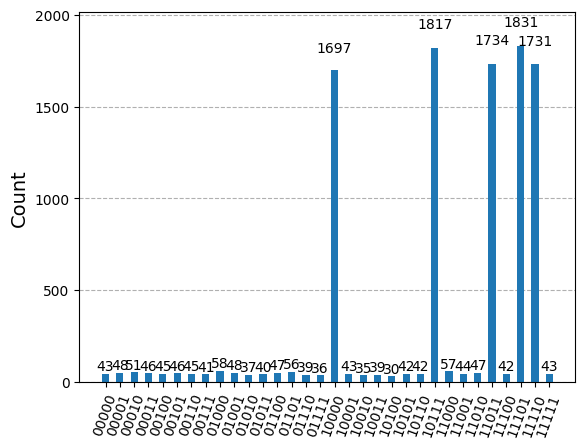

In [2]:
import math
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

def grover_oracle(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]

    num_qubits = len(marked_states[0])
    qc = QuantumCircuit(num_qubits)

    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target[ind] == '0']
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)

    return qc

# marked_states = ["011", "100"]
marked_states = ["10000", "10111", "11011", "11101", "11110"] # My case 2⋅(a+b+c+d+e)=(a+1)3
oracle = grover_oracle(marked_states)
grover_op = GroverOperator(oracle)
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()

# Decompose complex instructions to standard gates
qc = qc.decompose()

# Alternatively, transpile to the Aer simulator's basis gates
backend = AerSimulator()
qc = transpile(qc, backend=backend)

shots = 10_000
job = backend.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()

print("Measurement results:")
print(counts)
plot_histogram(counts)


In [1]:
for a in range(2):
    for b in range(2):
        for c in range(2):
            for d in range(2):
                for e in range(2):
                    left = 2 * (a + b + c + d + e) % 6
                    right = (a + 1)**3 % 6
                    if left==right:
                        print(f"Found:", a, b, c, d, e)

Found: 1 0 0 0 0
Found: 1 0 1 1 1
Found: 1 1 0 1 1
Found: 1 1 1 0 1
Found: 1 1 1 1 0
